<a href="https://colab.research.google.com/github/YvesAugusto/Object-Localization/blob/main/object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from skimage.transform import resize
from matplotlib.patches import Rectangle
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy

In [7]:
def base_model(img_dim):
  vgg = VGG16(
    input_shape=[img_dim, img_dim, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x) # location
  x2 = Dense(3, activation='softmax')(x) # object class
  x3 = Dense(1, activation='sigmoid')(x) # object appeared
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [11]:
def custom_loss(y_true, y_pred):
  # target is a 8-tuple
  # (row, col, depth, width, class1, class2, class3, object_appeared)

  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [4]:
IMG_SIZE = 200
new_height = 200
new_width = 200
from imageio import imread
img = imread('./drive/My Drive/bar_simpson.png')
img2 = imread('./drive/My Drive/marge_simpson.png')
img3 = imread('./drive/My Drive/homer_simpsomn.png')

images = [img, img2, img3]

back_ground = []
ra_fild12 = np.array(image.load_img('./drive/My Drive/ra_fild.png'))
ra_fild12 = resize(
            ra_fild12,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(ra_fild12)
lhz_dun = np.array(image.load_img('./drive/My Drive/lhz_dun.png'))
lhz_dun = resize(
            lhz_dun,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(lhz_dun)
orc_dun = np.array(image.load_img('./drive/My Drive/orc_dun.jpg'))
orc_dun = resize(
            orc_dun,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(orc_dun)
rachel_san = np.array(image.load_img('./drive/My Drive/rachel_san.jpeg'))
rachel_san = resize(
            rachel_san,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(rachel_san)
airplane = np.array(image.load_img('./drive/My Drive/airplane.jpeg'))
airplane = resize(
            airplane,
            (new_height, new_width),
            preserve_range=True).astype(np.uint8)
back_ground.append(airplane)

class_names = ['Homer', 'Bart', 'Marge']

In [16]:
images = np.array(images)
height, width, _ = images[0].shape

def train_generator(batch_size=64):
  while True:
    
    for _ in range(50):
      x_vec = np.arange(len(back_ground))
      X=[]
      for i in range(batch_size):
        np.random.shuffle(x_vec)
        index = x_vec[0]
        X.append(np.array(back_ground[index]))
      X = np.array(X)
      # X = np.zeros((batch_size, IMG_SIZE, IMG_SIZE, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        appear = (np.random.random() < 0.75)
        if appear:
          scale_vector = np.arange(0.125, 0.275, 0.05)
          np.random.shuffle(scale_vector)
          scale = scale_vector[0]
          new_height = int(height * scale)
          new_width = int(width * scale)

          # choose class
          s_idx = np.random.randint(3)

          obj = resize(
              images[s_idx],
              (new_height, new_width),
              preserve_range=True).astype(np.uint8)
          row0 = np.random.randint(IMG_SIZE - new_height)
          col0 = np.random.randint(IMG_SIZE - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width
          mask = (obj[:,:,3] == 0)
          windows = X[i,row0:row1,col0:col1,:]
          windows = np.expand_dims(mask, -1) * windows
          windows += obj[:,:,:3]
          X[i,row0:row1,col0:col1,:] = windows
          # plt.imshow(X[i,row0:row1,col0:col1,:])
          # plt.show()
          
          Y[i,0] = row0/IMG_SIZE
          Y[i,1] = col0/IMG_SIZE
          Y[i,2] = (row1 - row0)/IMG_SIZE
          Y[i,3] = (col1 - col0)/IMG_SIZE

          Y[i,4 + s_idx] = 1
        
        Y[i, 7] = appear
        
      
      yield X / 255., Y

In [17]:
model = base_model(IMG_SIZE)
model.fit_generator(
    train_generator(),
    steps_per_epoch=50,
    epochs=5
)

Epoch 1/5
50/50 [==============================] - 41s 826ms/step - loss: 1.2279
Epoch 2/5
50/50 [==============================] - 42s 834ms/step - loss: 0.4407
Epoch 3/5
50/50 [==============================] - 41s 820ms/step - loss: 0.4113
Epoch 4/5
50/50 [==============================] - 41s 828ms/step - loss: 0.4206
Epoch 5/5
50/50 [==============================] - 41s 813ms/step - loss: 0.4100


In [45]:
def predict():
  appear = (np.random.random() < 0.75)
  x_vec = np.arange(3)
  np.random.shuffle(x_vec)
  index = x_vec[0]
  x = np.array(back_ground[index])
  if appear:
    scale_vector = np.arange(0.125, 0.275, 0.05)
    np.random.shuffle(scale_vector)
    scale = scale_vector[0]
    new_height = int(height * scale)
    new_width = int(width * scale)

    # choose class
    s_idx = np.random.randint(3)

    obj = resize(
        images[s_idx],
        (new_height, new_width),
        preserve_range=True).astype(np.uint8)
    row0 = np.random.randint(IMG_SIZE - new_height)
    col0 = np.random.randint(IMG_SIZE - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width
    mask = (obj[:,:,3] == 0)
    windows = x[row0:row1,col0:col1,:]
    windows = np.expand_dims(mask, -1) * windows
    windows += obj[:,:,:3]
    x[row0:row1,col0:col1,:] = windows
    print("true:", row0, col0, row1, col1)
    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]
    
    # Draw the box
    row0 = int(p[0]*IMG_SIZE)
    col0 = int(p[1]*IMG_SIZE)
    row1 = int(row0 + p[2]*IMG_SIZE)
    col1 = int(col0 + p[3]*IMG_SIZE)
    print("pred:", row0, col0, row1, col1)
    classes = p[4:7]
    if np.argmax(classes) == 0:
      print(f'Class: Bart')
    elif np.argmax(classes) == 1:
      print(f'Class: Marge')
    elif np.argmax(classes) == 2:
      print(f'Class: Homer')
  
    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle(
        (p[1]*IMG_SIZE, p[0]*IMG_SIZE),
        p[3]*IMG_SIZE, p[2]*IMG_SIZE,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
  else:
    fig, ax = plt.subplots(1)
    print(f'No character on the background')
    ax.imshow(x.astype(np.uint8))
    plt.show()


true: 11 35 81 105
pred: 15 30 81 94
Class: Homer


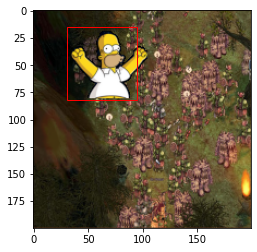

In [65]:
predict()